This is an example notebook showing how embedding centroids can be calculated and used to do efficient inference on an evaluation set.

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from pathlib import Path
from tqdm import tqdm

# load NLLB model
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")
model.eval()


c:\Users\jbmcg\Documents\GitHub\Y2IrishGPT\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
       

In [2]:
def get_sentence_embeddings(texts, model, tokenizer, lang="eng_Latn", batch_size=32):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to("cuda")
        with torch.no_grad():
            outputs = model.get_encoder()(**enc)
            hidden = outputs.last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1)
            mean_pooled = (hidden * mask).sum(1) / mask.sum(1)
            mean_pooled = torch.nn.functional.normalize(mean_pooled, p=2, dim=1)
        all_embs.append(mean_pooled.cpu())
    return torch.cat(all_embs)


In [3]:
root = Path("train")
domain_texts = {}
for domain_dir in root.iterdir():
    if domain_dir.is_dir():
        text_file = domain_dir / "english_clean.txt"
        with open(text_file, "r", encoding="utf-8") as f:
            sentences = [line.strip() for line in f if line.strip()]
        domain_texts[domain_dir.name] = sentences

print({k: len(v) for k, v in domain_texts.items()})


{'general': 474874, 'legal': 611956, 'medical': 33421, 'wikinews': 99074}


In [4]:
domain_embeddings = {}
for domain, texts in domain_texts.items():
    print(f"Encoding domain: {domain}")
    embs = get_sentence_embeddings(texts, model, tokenizer)
    domain_embeddings[domain] = embs


Encoding domain: general


100%|██████████| 14840/14840 [06:37<00:00, 37.32it/s] 


Encoding domain: legal


100%|██████████| 19124/19124 [16:43<00:00, 19.05it/s]


Encoding domain: medical


100%|██████████| 1045/1045 [00:35<00:00, 29.50it/s]


Encoding domain: wikinews


100%|██████████| 3097/3097 [01:52<00:00, 27.49it/s]


In [5]:
domain_centroids = {
    domain: torch.mean(embs, dim=0)
    for domain, embs in domain_embeddings.items()
}


In [6]:
for d in domain_centroids:
    domain_centroids[d] = torch.nn.functional.normalize(domain_centroids[d], p=2, dim=0)


In [7]:
torch.save(domain_embeddings, "domain_embeddings.pt")
torch.save(domain_centroids, "domain_centroids.pt")

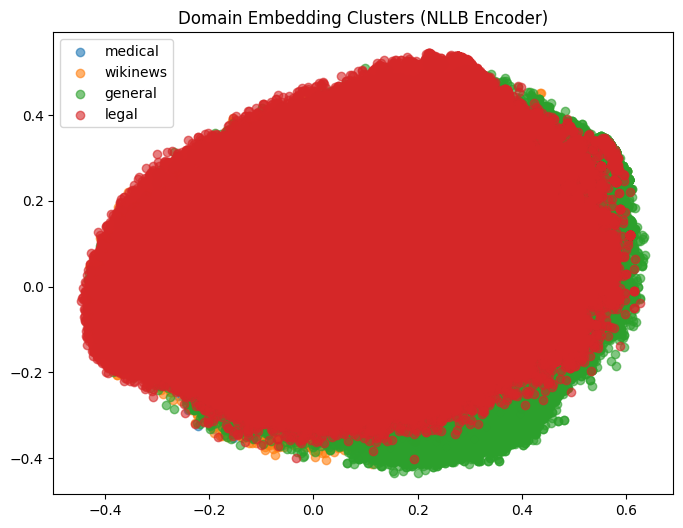

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

labels = []
X = []
for domain, embs in domain_embeddings.items():
    X.append(embs)
    labels += [domain] * len(embs)
X = torch.cat(X).numpy()

pca = PCA(n_components=2)
proj = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for d in set(labels):
    mask = [i for i, l in enumerate(labels) if l == d]
    plt.scatter(proj[mask, 0], proj[mask, 1], label=d, alpha=0.6)
plt.legend()
plt.title("Domain Embedding Clusters (NLLB Encoder)")
plt.show()


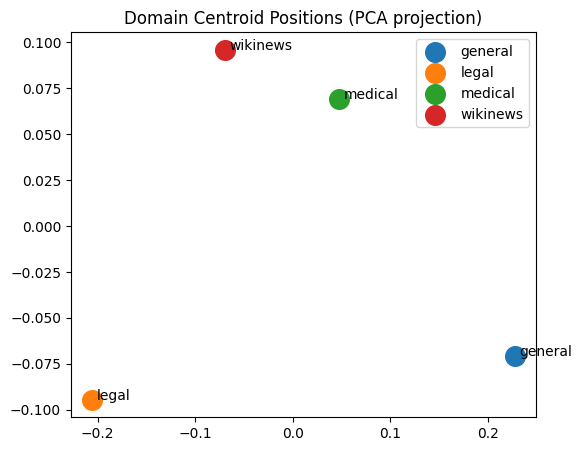

In [10]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Stack centroids into matrix
domain_names = list(domain_centroids.keys())
centroid_matrix = torch.stack([domain_centroids[d] for d in domain_names]).numpy()

# Reduce to 2D
pca = PCA(n_components=2)
proj = pca.fit_transform(centroid_matrix)

# Plot centroids
plt.figure(figsize=(6,5))
for i, name in enumerate(domain_names):
    plt.scatter(proj[i,0], proj[i,1], s=200, label=name)
    plt.text(proj[i,0]+0.005, proj[i,1], name, fontsize=10)

plt.title("Domain Centroid Positions (PCA projection)")
plt.legend()
plt.show()


In [11]:
from pathlib import Path

root = Path("test_embedding")
output_dir = Path("combined_tsvs")
output_dir.mkdir(exist_ok=True)

# detect domain prefixes automatically
domains = set(f.name.split("_")[0] for f in root.glob("*_english_clean.txt"))

for domain in domains:
    eng_path = root / f"{domain}_english_clean.txt"
    ir_path = root / f"{domain}_irish_clean.txt"
    out_path = output_dir / f"{domain}.tsv"

    with open(eng_path, "r", encoding="utf-8") as f_eng, \
         open(ir_path, "r", encoding="utf-8") as f_ir, \
         open(out_path, "w", encoding="utf-8") as f_out:

        for eng_line, ir_line in zip(f_eng, f_ir):
            eng = eng_line.strip()
            ir = ir_line.strip()
            if eng and ir:
                f_out.write(f"{eng}\t{ir}\n")

    print(f"✅ Wrote {out_path}")


✅ Wrote combined_tsvs\med.tsv
✅ Wrote combined_tsvs\general.tsv
✅ Wrote combined_tsvs\legal.tsv
✅ Wrote combined_tsvs\wiki.tsv


In [12]:
from pathlib import Path

input_dir = Path("combined_tsvs")
output_path = Path("all_domains.tsv")

with open(output_path, "w", encoding="utf-8") as fout:
    for file in input_dir.glob("*.tsv"):
        with open(file, "r", encoding="utf-8") as fin:
            for line in fin:
                fout.write(line)

print(f"✅ Combined all domains into {output_path}")


✅ Combined all domains into all_domains.tsv


In [14]:
import torch
import csv
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity


# ---------------------------------------------------------------------
# Load model and tokenizer
# ---------------------------------------------------------------------
model_name = "facebook/nllb-200-distilled-600M"
print(f"🔹 Loading model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")
model.eval()
print("✅ Model and tokenizer loaded successfully.")


# ---------------------------------------------------------------------
# Load domain centroids
# ---------------------------------------------------------------------
centroid_path = "domain_centroids.pt"
print(f"📦 Loading domain centroids from: {centroid_path}")
domain_centroids = torch.load(centroid_path)

domain_names = list(domain_centroids.keys())
centroid_stack = torch.stack([domain_centroids[d] for d in domain_names])
centroid_stack = torch.nn.functional.normalize(centroid_stack, p=2, dim=1)
print(f"✅ Loaded {len(domain_names)} domain centroids: {', '.join(domain_names)}")


# ---------------------------------------------------------------------
# Sentence embedding function
# ---------------------------------------------------------------------
def get_sentence_embeddings(texts, model, tokenizer, batch_size=16, lang="eng_Latn"):
    """Generate normalized mean-pooled encoder embeddings for sentences."""
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to("cuda")
        with torch.no_grad():
            enc_out = model.get_encoder()(**inputs)
            hidden = enc_out.last_hidden_state
            mask = inputs["attention_mask"].unsqueeze(-1)
            mean_pooled = (hidden * mask).sum(1) / mask.sum(1)
            mean_pooled = torch.nn.functional.normalize(mean_pooled, p=2, dim=1)
        all_embeddings.append(mean_pooled.cpu())
    return torch.cat(all_embeddings)


# ---------------------------------------------------------------------
# Load input dataset
# ---------------------------------------------------------------------
input_path = Path("data/all_domains.tsv")
print(f"📂 Reading sentences from: {input_path}")

sentences, translations, true_domains = [], [], []
with open(input_path, "r", encoding="utf-8") as f:
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
        if len(row) >= 2:
            sentences.append(row[0])
            translations.append(row[1])
            true_domains.append(row[2] if len(row) > 2 else "unknown")

print(f"✅ Loaded {len(sentences):,} sentence pairs.")


# ---------------------------------------------------------------------
# Compute sentence embeddings
# ---------------------------------------------------------------------
print("🧠 Computing sentence embeddings...")
embeddings = get_sentence_embeddings(sentences, model, tokenizer)
print("✅ Embeddings computed.")


# ---------------------------------------------------------------------
# Compute cosine similarities to domain centroids
# ---------------------------------------------------------------------
print("📊 Computing cosine similarities to domain centroids...")
similarities = torch.matmul(embeddings, centroid_stack.T).numpy()  # [num_sentences x num_domains]

# Hard label: assign nearest centroid
pred_indices = np.argmax(similarities, axis=1)
pred_domains = [domain_names[i] for i in pred_indices]

# Soft weights (normalized similarities)
soft_weights = torch.nn.functional.softmax(torch.tensor(similarities), dim=1).numpy()

print("✅ Domain predictions complete.")


# ---------------------------------------------------------------------
# Save results
# ---------------------------------------------------------------------
output_path = Path("data/all_domains_with_predicted_labels.tsv")
print(f"💾 Saving results to: {output_path}")

with open(output_path, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    header = ["english", "irish", "pred_domain"] + [f"sim_{d}" for d in domain_names]
    writer.writerow(header)

    for eng, ir, pred, sim_row in zip(sentences, translations, pred_domains, similarities):
        writer.writerow([eng, ir, pred] + list(sim_row))

print(f"✅ Wrote {len(sentences):,} labeled sentences to {output_path}")


✅ Wrote all_domains_with_predicted_labels.tsv with 91904 labeled sentences


In [15]:
import csv
from pathlib import Path
from collections import defaultdict

input_path = Path("all_domains_with_predicted_labels.tsv")
output_dir = Path("split_by_predicted_domain")
output_dir.mkdir(exist_ok=True)

# 1️⃣ Read the labeled TSV
domain_rows = defaultdict(list)

with open(input_path, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for row in reader:
        domain = row["pred_domain"]
        # keep only english, irish, and the predicted domain label
        domain_rows[domain].append([row["english"], row["irish"], row["pred_domain"]])

# 2️⃣ Write one file per domain
for domain, rows in domain_rows.items():
    out_path = output_dir / f"{domain}.tsv"
    with open(out_path, "w", encoding="utf-8", newline="") as f_out:
        writer = csv.writer(f_out, delimiter="\t")
        writer.writerow(["english", "irish", "domain"])  # header
        writer.writerows(rows)
    print(f"✅ Wrote {len(rows)} rows to {out_path}")


✅ Wrote 67086 rows to split_by_predicted_domain\general.tsv
✅ Wrote 7426 rows to split_by_predicted_domain\legal.tsv
✅ Wrote 8875 rows to split_by_predicted_domain\medical.tsv
✅ Wrote 8517 rows to split_by_predicted_domain\wikinews.tsv


In [16]:
from pathlib import Path
import csv

input_dir = Path("split_by_predicted_domain")
output_dir = Path("domain_texts")
output_dir.mkdir(exist_ok=True)

for tsv_file in input_dir.glob("*.tsv"):
    domain = tsv_file.stem  # e.g. "general"
    eng_out = output_dir / f"{domain}_english.txt"
    ir_out = output_dir / f"{domain}_irish.txt"

    with open(tsv_file, "r", encoding="utf-8") as f_in, \
         open(eng_out, "w", encoding="utf-8") as f_eng, \
         open(ir_out, "w", encoding="utf-8") as f_ir:

        reader = csv.DictReader(f_in, delimiter="\t")
        for row in reader:
            eng = row["english"].strip()
            ir = row["irish"].strip()
            if eng and ir:
                f_eng.write(eng + "\n")
                f_ir.write(ir + "\n")

    print(f"✅ Wrote {eng_out.name} and {ir_out.name}")


✅ Wrote general_english.txt and general_irish.txt
✅ Wrote legal_english.txt and legal_irish.txt
✅ Wrote medical_english.txt and medical_irish.txt
✅ Wrote wikinews_english.txt and wikinews_irish.txt
